In [1]:
## General libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
import math
import pprint

## My libraries ww
import comms

In [2]:
data = comms.load_jsons("products.json") ## list of jsons, TESTING:    pprint.pprint(data[0], depth=1)
user_item_df = comms.user_item_dataframe(data) ## dataframe ["context", "word"] = ["user", "product"]
word_bags, context_ids = comms.create_contexts(user_item_df, remove_treshold = 1) ## list of lists of product_ids, list of user_ids 

In [3]:
test_size = min(len(word_bags)//5, 500) ## number of users to make testing set of 
test_indices = np.random.choice(len(word_bags), test_size)
train_indices = [i for i in range(len(word_bags)) if i not in test_indices]

word_bags_test = [word_bags[i] for i in test_indices]
word_bags_train = [word_bags[i] for i in train_indices]

context_ids_test = [context_ids[i] for i in test_indices]

In [4]:
del data

In [5]:
vocabulary = list(set([w for wb in word_bags_train for w in wb]))

In [29]:
user_indices = []
item_indices = []
rating_values = []

In [30]:
for user_index in range(len(word_bags_train)): 
    wb = word_bags_train[user_index]
    it_ind = [vocabulary.index(unw) for unw in set(wb)]
    rat_int = [wb.count(unw) for unw in set(wb)]
    u_ind = [user_index for i in range(len(it_ind))]

    
    
    user_indices.extend(u_ind)
    item_indices.extend(it_ind)
    rating_values.extend(rat_int)

In [62]:
lda = .01          ## weight of regularization 
lr = 1.0           ## learning rate
max_iter = 20000   ## number of iterations in optimization 

In [35]:
num_users = len(word_bags_train)
rank = 32
num_items = len(vocabulary)
num_ratings = len(user_indices)

In [40]:
user_indices

array([   0,    0,    0, ..., 7789, 7790, 7790])

In [37]:
user_indices = np.array(user_indices)
item_indices = np.array(item_indices)
rating_values = np.array(rating_values)

In [55]:
test_indices = np.random.choice(len(user_indices), 1000, replace=False)
train_indices = [i for i in range(len(user_indices)) if i not in test_indices]

In [60]:
user_indices_train = user_indices[train_indices] 
item_indices_train = item_indices[train_indices]
rating_values_train = rating_values[train_indices]

user_indices_test = user_indices[test_indices]
item_indices_test = item_indices[test_indices]
rating_values_test = rating_values[test_indices]

In [61]:
# Initialize the matrix factors from random normals with mean 0. W will
# represent users and H will represent items.
W = tf.Variable(tf.truncated_normal([num_users, rank], stddev=0.2, mean=0), name="users")
H = tf.Variable(tf.truncated_normal([rank, num_items], stddev=0.2, mean=0), name="items")

result = tf.matmul(W, H)

# Now we just want the values represented by the pairs of user and item
# indices for which we had known ratings. 
indices = tf.stack([user_indices_train, item_indices_train], axis=1)
result_values = tf.gather_nd(result, indices, name='predicted_rating')

# Calculate the difference between the predicted ratings and the actual
# ratings. The predicted ratings are the values obtained form the matrix
# multiplication with the mean rating added on.
diff_op = tf.subtract(result_values, rating_values_train, name="raw_training_error")

base_cost = tf.reduce_sum(tf.square(diff_op, name="squared_difference"), name="sum_squared_error")
# Add regularization.
regularizer = tf.multiply(tf.add(tf.reduce_sum(tf.square(W)), tf.reduce_sum(tf.square(H))), lda, name="regularize")
cost = tf.div(tf.add(base_cost, regularizer), num_ratings * 2, name="average_error")

# Use an exponentially decaying learning rate.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step, 10000, 0.96, staircase=True)


optimizer = tf.train.GradientDescentOptimizer(learning_rate)
# Passing global_step to minimize() will increment it at each step so
# that the learning rate will be decayed at the specified intervals.
train_step = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()


In [63]:
sess = tf.Session()
sess.run(init)

for i in range(max_iter):
    if i % 500 == 0:
        cost_r, base_cost_r, regularizer_r = sess.run([cost * num_ratings * 2, base_cost, regularizer])
        print("Cost at",i,"th iteration was: ", cost_r, "  base cost: ", base_cost_r, "  regul.: ", regularizer_r)
    else:
        sess.run(train_step)
        
final_res, final_W, final_H = sess.run([result, W, H])

Cost at 0 th iteration was:  96885.5   base cost:  96788.2   regul.:  97.3543
Cost at 500 th iteration was:  84148.3   base cost:  84048.5   regul.:  99.7017
Cost at 1000 th iteration was:  59218.4   base cost:  59107.9   regul.:  110.54
Cost at 1500 th iteration was:  38197.8   base cost:  38071.2   regul.:  126.625
Cost at 2000 th iteration was:  24544.2   base cost:  24401.4   regul.:  142.822
Cost at 2500 th iteration was:  15942.0   base cost:  15784.6   regul.:  157.363
Cost at 3000 th iteration was:  10641.9   base cost:  10472.3   regul.:  169.572
Cost at 3500 th iteration was:  7320.66   base cost:  7141.13   regul.:  179.528
Cost at 4000 th iteration was:  5169.49   base cost:  4981.89   regul.:  187.598
Cost at 4500 th iteration was:  3732.25   base cost:  3538.08   regul.:  194.164
Cost at 5000 th iteration was:  2748.9   base cost:  2549.36   regul.:  199.54
Cost at 5500 th iteration was:  2063.66   base cost:  1859.7   regul.:  203.965
Cost at 6000 th iteration was:  1578

In [48]:
import matplotlib.pyplot as plt

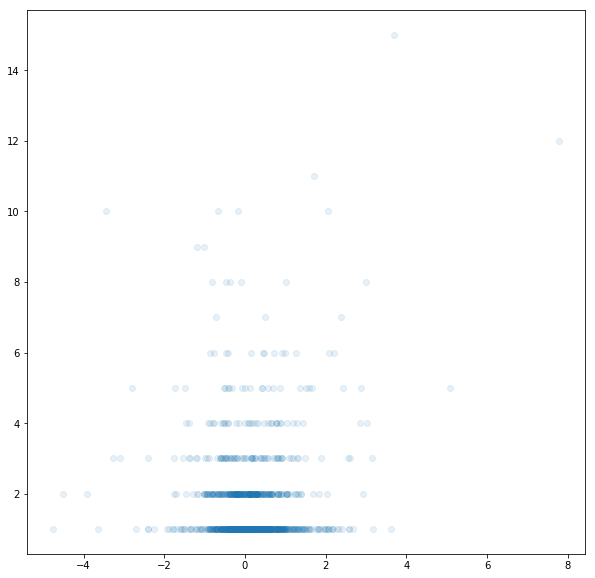

In [65]:
plt.figure(figsize = (10,10))
plt.scatter(final_res[user_indices_test, item_indices_test], rating_values_test, alpha=0.1)
plt.show()